### 高排队时间任务的资源请求特征分析

数据样例：
+--------------------+--------------------+------+
|         cpu_request|         mem_request|failed|
+--------------------+--------------------+------+
|   0.018402099609375|0.001302719116210...|     0|
|   0.007293701171875| 0.00725555419921875|     0|
| 0.00704193115234375|0.001302719116210...|     0|
|0.001241683959960...|    2.13623046875E-4|     0|
|8.802413940429688E-4|  0.0010528564453125|     0|
+--------------------+--------------------+------+
only showing top 5 rows

有效记录总数：398771
采样转换中...
转换成功，样本数：4000


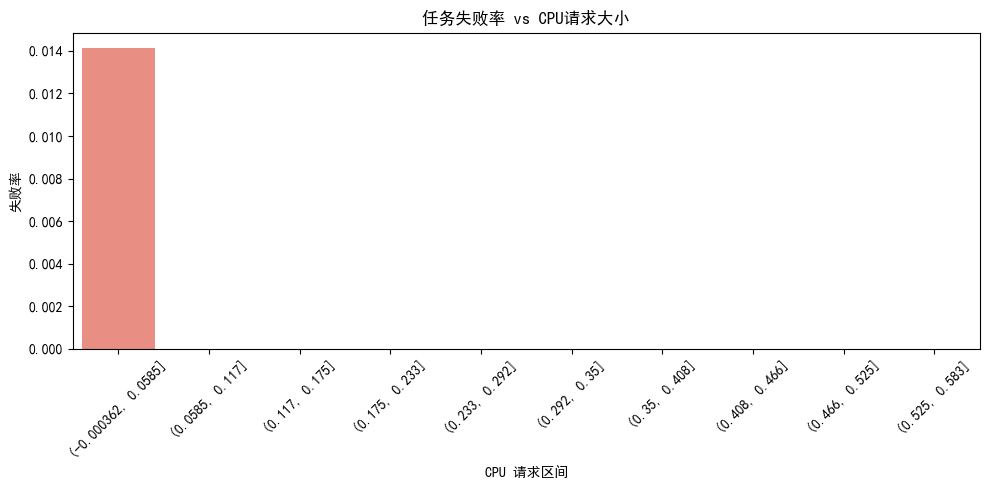

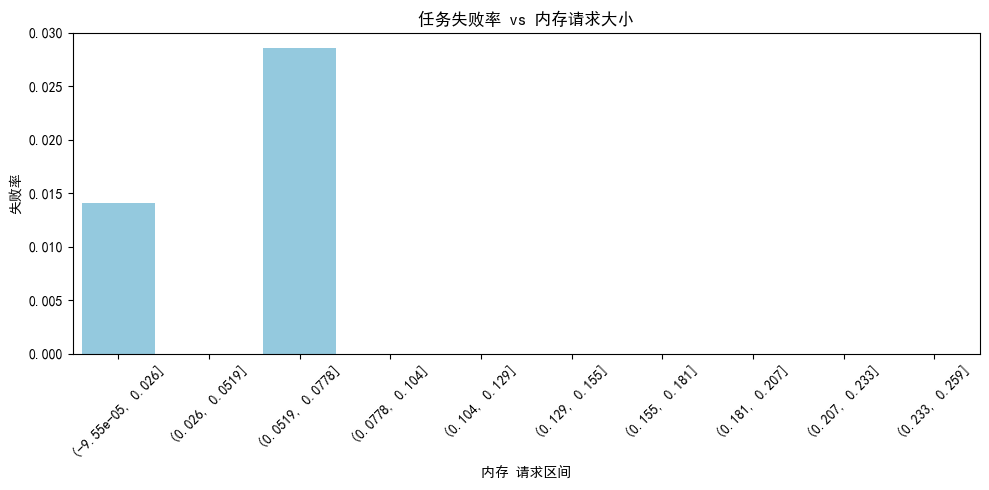

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract

# 初始化 Spark（优化配置）
spark = SparkSession.builder \
    .appName("EDA_Failure_Rate_vs_Resource") \
    .config("spark.executor.python.worker.timeout", "300") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "5000") \
    .getOrCreate()

# 读取数据（请根据实际路径调整）
df_clean = spark.read.parquet("../data/cleaned_borg_data.parquet")

# 高效解析字段，提取 cpus 和 memory
pattern_cpu = r"'cpus':\s*([\d\.]+)"
pattern_mem = r"'memory':\s*([\d\.]+)"

# 过滤非空和有效资源请求
df_parsed = df_clean.filter(
    col("resource_request").isNotNull() & col("failed").isNotNull()
).withColumn(
    "cpu_request", regexp_extract(col("resource_request"), pattern_cpu, 1).cast("double")
).withColumn(
    "mem_request", regexp_extract(col("resource_request"), pattern_mem, 1).cast("double")
).filter(
    (col("cpu_request") > 0) & (col("mem_request") > 0)
)

# 打印样例和有效行数
print("数据样例：")
df_parsed.select("cpu_request", "mem_request", "failed").show(5)
print(f"有效记录总数：{df_parsed.count()}")

# 高效采样后转换为 Pandas
sample_size = 4000
fraction = 0.1

print("采样转换中...")
df_all = df_parsed.select("cpu_request", "mem_request", "failed") \
    .sample(withReplacement=False, fraction=fraction, seed=42) \
    .limit(sample_size) \
    .toPandas()
print(f"转换成功，样本数：{len(df_all)}")

# 配置中文支持和负号显示
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# CPU 请求分箱并计算失败率
df_all["cpu_bin"] = pd.cut(df_all["cpu_request"], bins=10)
cpu_grouped = df_all.groupby("cpu_bin", observed=False)["failed"].agg(["count", "sum"])
cpu_grouped["failure_rate"] = cpu_grouped["sum"] / cpu_grouped["count"]

# CPU 分布图
plt.figure(figsize=(10, 5))
sns.barplot(x=cpu_grouped.index.astype(str), y=cpu_grouped["failure_rate"], color="salmon")
plt.title("任务失败率 vs CPU请求大小")
plt.ylabel("失败率")
plt.xlabel("CPU 请求区间")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# MEM 请求分箱并计算失败率
df_all["mem_bin"] = pd.cut(df_all["mem_request"], bins=10)
mem_grouped = df_all.groupby("mem_bin", observed=False)["failed"].agg(["count", "sum"])
mem_grouped["failure_rate"] = mem_grouped["sum"] / mem_grouped["count"]

# MEM 分布图
plt.figure(figsize=(10, 5))
sns.barplot(x=mem_grouped.index.astype(str), y=mem_grouped["failure_rate"], color="skyblue")
plt.title("任务失败率 vs 内存请求大小")
plt.ylabel("失败率")
plt.xlabel("内存 请求区间")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 关闭 Spark
spark.stop()

采样转换中...
转换完成，样本数： 3486


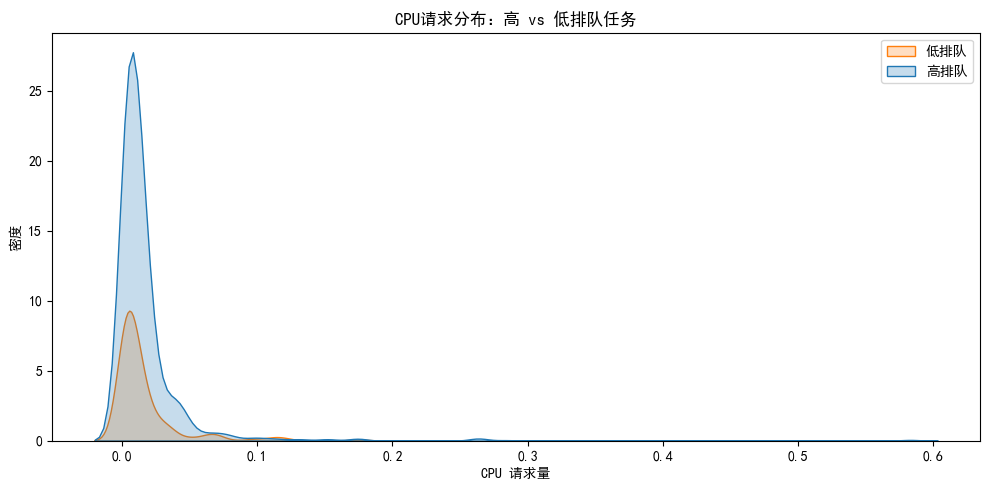

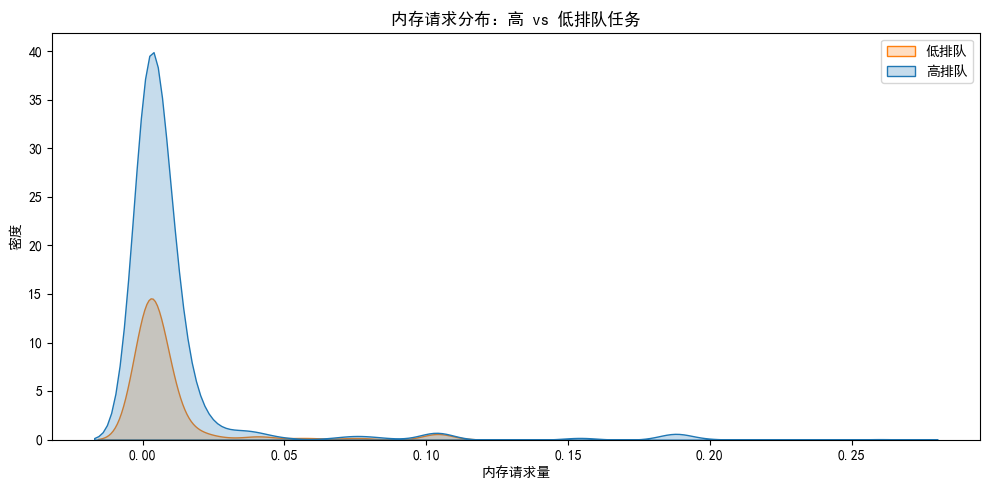

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract

# 初始化 Spark（优化配置）
spark = SparkSession.builder \
    .appName("EDA_QueueingDelay_vs_Resource") \
    .config("spark.executor.python.worker.timeout", "300") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "5000") \
    .getOrCreate()

# 读取数据
df_clean = spark.read.parquet("../data/cleaned_borg_data.parquet")

# 解析资源字段
pattern_cpu = r"'cpus':\s*([\d\.]+)"
pattern_mem = r"'memory':\s*([\d\.]+)"

df_parsed = df_clean.filter(
    col("queueing_delay").isNotNull() &
    col("resource_request").isNotNull()
).withColumn(
    "cpu_request", regexp_extract(col("resource_request"), pattern_cpu, 1).cast("double")
).withColumn(
    "mem_request", regexp_extract(col("resource_request"), pattern_mem, 1).cast("double")
).filter(
    (col("cpu_request") > 0) & (col("mem_request") > 0)
)

# 转为 Pandas 采样数据
print("采样转换中...")
df_sample = df_parsed.select("queueing_delay", "cpu_request", "mem_request") \
    .sample(False, 0.01, seed=42).limit(5000).toPandas()
print("转换完成，样本数：", len(df_sample))

# 按排队时间 75 分位划分为高/低队列
delay_threshold = df_sample["queueing_delay"].quantile(0.75)
df_sample["queue_class"] = (df_sample["queueing_delay"] > delay_threshold).astype(int)

# 设置中文字体和样式
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘图：CPU请求分布
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_sample, x="cpu_request", hue="queue_class", fill=True)
plt.title("CPU请求分布：高 vs 低排队任务")
plt.xlabel("CPU 请求量")
plt.ylabel("密度")
plt.legend(labels=["低排队", "高排队"])
plt.tight_layout()
plt.show()

# 绘图：MEM请求分布
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_sample, x="mem_request", hue="queue_class", fill=True)
plt.title("内存请求分布：高 vs 低排队任务")
plt.xlabel("内存请求量")
plt.ylabel("密度")
plt.legend(labels=["低排队", "高排队"])
plt.tight_layout()
plt.show()

# Spark关闭
spark.stop()

### priority / scheduling_class 分布

采样转换中...
转换完成，样本数： 3486


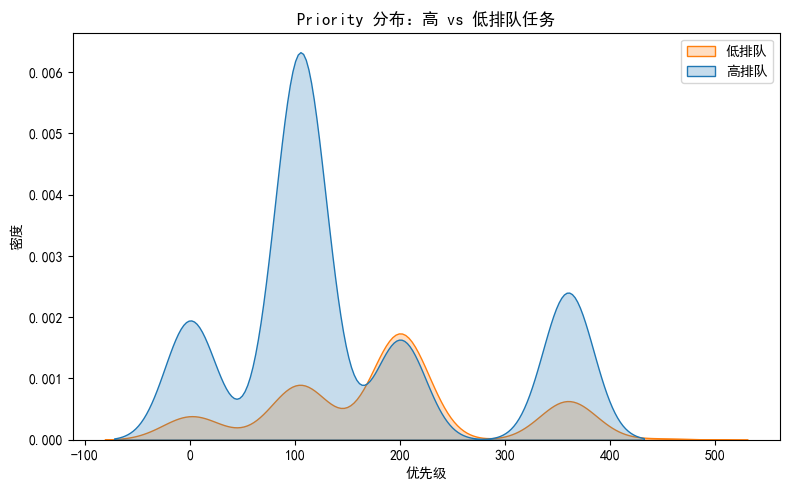

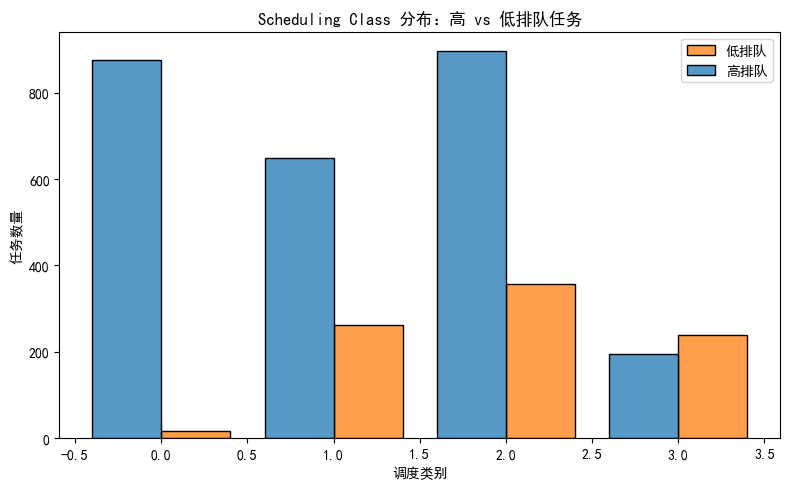

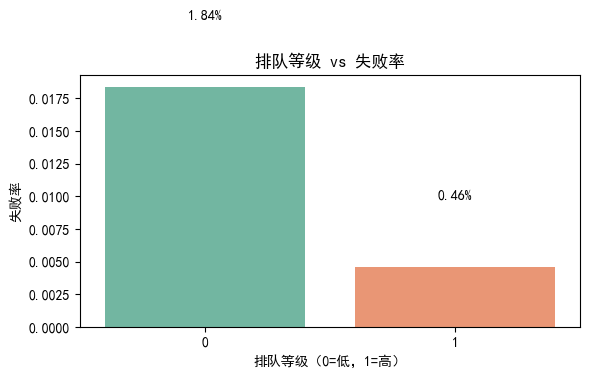

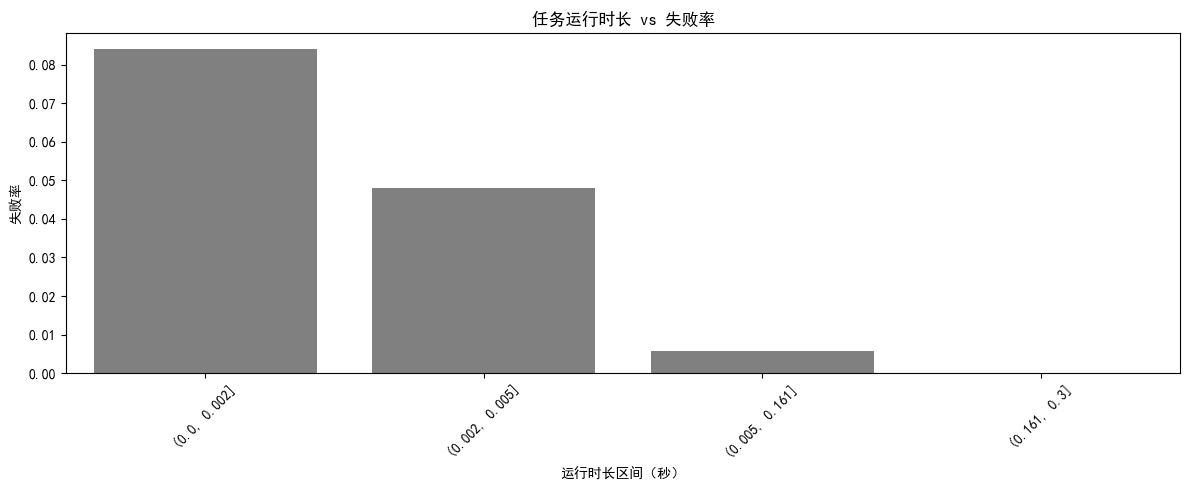


资源利用率字段总体描述
count     3487.000000
mean       435.484969
std       3759.810719
min          0.000000
25%          0.035488
50%          0.296225
75%          0.753372
max      41125.541126
Name: resource_efficiency, dtype: float64

Top 10 最大资源利用率值
      resource_efficiency  failed
28           41125.541126       0
1101         41125.541126       0
1847         41125.541126       0
1476         41125.541126       0
1536         41125.541126       0
2469         41125.541126       0
396          41125.541126       0
2359         41125.541126       0
2003         41125.541126       0
1733         41125.541126       0


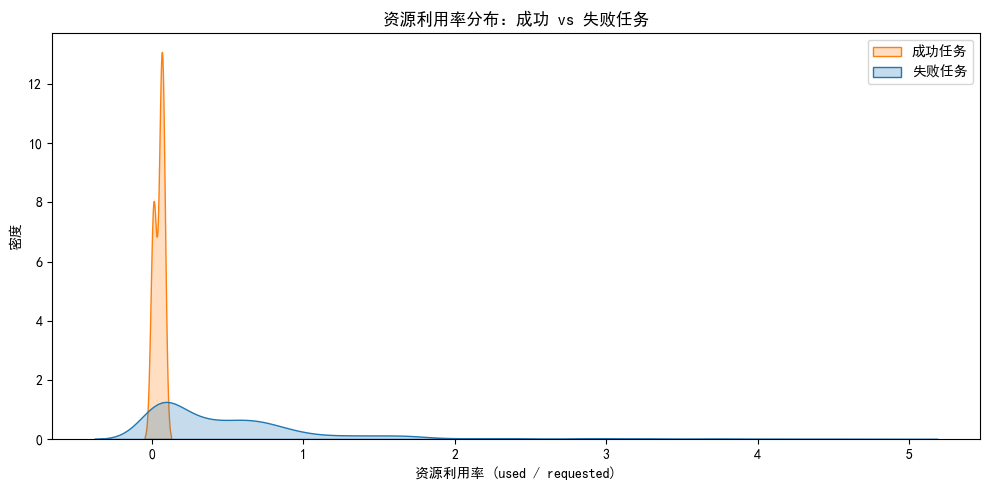

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract

# 初始化 Spark（优化配置）
spark = SparkSession.builder \
    .appName("EDA_QueueingDelay_vs_Resource") \
    .config("spark.executor.python.worker.timeout", "300") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "5000") \
    .getOrCreate()

# 读取数据
df_clean = spark.read.parquet("../data/cleaned_borg_data.parquet")

# 解析资源字段
pattern_cpu = r"'cpus':\s*([\d\.]+)"
pattern_mem = r"'memory':\s*([\d\.]+)"

df_parsed = df_clean.filter(
    col("queueing_delay").isNotNull() &
    col("resource_request").isNotNull() &
    col("priority").isNotNull() &
    col("scheduling_class").isNotNull() &
    col("failed").isNotNull() &
    col("run_duration").isNotNull()
).withColumn(
    "cpu_request", regexp_extract(col("resource_request"), pattern_cpu, 1).cast("double")
).withColumn(
    "mem_request", regexp_extract(col("resource_request"), pattern_mem, 1).cast("double")
).filter(
    (col("cpu_request") > 0) & (col("mem_request") > 0)
)

# 转为 Pandas 采样数据
print("采样转换中...")
df_sample = df_parsed.select("queueing_delay", "cpu_request", "mem_request", "priority", "scheduling_class", "failed", "run_duration") \
    .sample(False, 0.01, seed=42).limit(5000).toPandas()
print("转换完成，样本数：", len(df_sample))

# 按排队时间 75 分位划分为高/低队列
delay_threshold = df_sample["queueing_delay"].quantile(0.75)
df_sample["queue_class"] = (df_sample["queueing_delay"] > delay_threshold).astype(int)

# 设置中文字体和样式
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘图：Priority 分布对比
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_sample, x="priority", hue="queue_class", fill=True)
plt.title("Priority 分布：高 vs 低排队任务")
plt.xlabel("优先级")
plt.ylabel("密度")
plt.legend(labels=["低排队", "高排队"])
plt.tight_layout()
plt.show()

# 绘图：Scheduling Class 分布对比
plt.figure(figsize=(8, 5))
sns.histplot(data=df_sample, x="scheduling_class", hue="queue_class", multiple="dodge", shrink=0.8, discrete=True)
plt.title("Scheduling Class 分布：高 vs 低排队任务")
plt.xlabel("调度类别")
plt.ylabel("任务数量")
plt.legend(labels=["低排队", "高排队"])
plt.tight_layout()
plt.show()

# 绘图：排队等级 vs 失败率
failure_stats = df_sample.groupby("queue_class")["failed"].agg(["count", "sum"])
failure_stats["failure_rate"] = failure_stats["sum"] / failure_stats["count"]

plt.figure(figsize=(6, 4))
sns.barplot(data=failure_stats.reset_index(), x="queue_class", y="failure_rate", hue="queue_class", palette="Set2", legend=False)
for i, rate in enumerate(failure_stats["failure_rate"]):
    plt.text(i, rate + 0.005, f"{rate:.2%}", ha='center', va='bottom', fontsize=10)
plt.title("排队等级 vs 失败率")
plt.xlabel("排队等级（0=低，1=高）")
plt.ylabel("失败率")
plt.tight_layout()
plt.show()

# 新增分析：运行时长 vs 失败率（处理重复 bin 问题）
df_sample["run_bin"] = pd.qcut(df_sample["run_duration"] / 1e9, q=10, duplicates="drop")
fail_by_runtime = df_sample.groupby("run_bin", observed=False)["failed"].agg(["count", "sum"])
fail_by_runtime["failure_rate"] = fail_by_runtime["sum"] / fail_by_runtime["count"]

plt.figure(figsize=(12, 5))
sns.barplot(x=fail_by_runtime.index.astype(str), y=fail_by_runtime["failure_rate"], color="gray")
plt.xticks(rotation=45)
plt.title("任务运行时长 vs 失败率")
plt.xlabel("运行时长区间（秒）")
plt.ylabel("失败率")
plt.tight_layout()
plt.show()

# 新增分析：资源利用率分布（成功 vs 失败任务）
df_diag = df_clean.filter(
    col("resource_request").isNotNull() &
    col("average_usage").isNotNull() &
    col("failed").isNotNull()
).withColumn(
    "requested_cpus", regexp_extract(col("resource_request"), r"'cpus':\s*([\d.]+)", 1).cast("double")
).withColumn(
    "used_average_cpus", regexp_extract(col("average_usage"), r"'cpus':\s*([\d.]+)", 1).cast("double")
).withColumn(
    "resource_efficiency", (col("used_average_cpus") / col("requested_cpus"))
).filter(
    (col("requested_cpus") > 0) & (col("used_average_cpus") >= 0)
).select("resource_efficiency", "failed")

# 转为 pandas 并过滤异常值
df_diag_pd = df_diag.sample(False, 0.01, seed=42).limit(5000).toPandas()
print("\n资源利用率字段总体描述")
print(df_diag_pd["resource_efficiency"].describe())
print("\nTop 10 最大资源利用率值")
print(df_diag_pd.sort_values("resource_efficiency", ascending=False).head(10))

# 过滤极端值
df_diag_pd = df_diag_pd[(df_diag_pd["resource_efficiency"] > 0.01) & (df_diag_pd["resource_efficiency"] < 5)]

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_diag_pd, x="resource_efficiency", hue="failed", fill=True, common_norm=False)
plt.title("资源利用率分布：成功 vs 失败任务")
plt.xlabel("资源利用率 (used / requested)")
plt.ylabel("密度")
plt.legend(labels=["成功任务", "失败任务"])
plt.tight_layout()
plt.show()

# Spark关闭
spark.stop()